# Calibrating Quicksurvey using Gaussian Mixture Models

The goal of this notebook is to use noiseless spectroscopic simulations from `desitarget.select_mock_targets` to calibrate a set of Gaussian mixture models (GMMs) which can be used in turn to simulate much larger datasets just at the catalog level, i.e., *quicksurvey*.

Here, we demonstrate the proof-of-concept using just ELGs, although the infrastructure can be extended easily to all the principle target classes.

In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [35]:
from astropy.table import Table
from sklearn.mixture import GaussianMixture as GMM

In [3]:
from desitarget.targetmask import desi_mask

In [36]:
import seaborn as sns
sns.set(style='ticks', color_codes=True)

In [4]:
%matplotlib inline

### Read the reference truth catalog.

In [5]:
truthdir = os.path.join(os.getenv('DESI_ROOT'), 'datachallenge', 
                        'reference_runs', '18.2a', 'targets')

In [6]:
truth = Table.read(os.path.join(truthdir, 'truth.fits')).to_pandas()
truth.head()

,TARGETID,MOCKID,CONTAM_TARGET,TRUEZ,TRUESPECTYPE,TEMPLATETYPE,TEMPLATESUBTYPE,TEMPLATEID,SEED,MAG,...,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,OIIFLUX,HBETAFLUX,TEFF,LOGG,FEH
0,288230398217945088,15594312,0,0.134829,GALAXY,BGS,,3627,1482857632,19.810371,...,5.244956,13.027136,22.072302,17.045567,11.077766,-1.0,0.000000e+00,-1.0,-1.0,-1.0
1,288230398217945089,19713506,0,0.131031,GALAXY,BGS,,3100,1847516324,18.553574,...,23.236532,39.164349,57.429871,52.143738,38.030403,-1.0,1.624847e-15,-1.0,-1.0,-1.0
2,288230398217945090,17928726,0,0.145801,GALAXY,BGS,,1281,1159188526,18.351431,...,19.850098,50.108429,86.518089,74.636200,51.438339,-1.0,0.000000e+00,-1.0,-1.0,-1.0
3,288230398217945091,19762079,0,0.295097,GALAXY,BGS,,5168,1664239784,17.993166,...,18.452414,71.998535,149.989059,178.461807,126.496735,-1.0,0.000000e+00,-1.0,-1.0,-1.0
4,288230398217945092,13979089,0,0.404595,GALAXY,BGS,,6077,236582212,20.154673,...,2.099783,9.958090,21.838903,36.395954,28.041195,-1.0,0.000000e+00,-1.0,-1.0,-1.0


### Extract the target-specific quantities of interest.

The "quantities of interest" are quantities that must be derived from spectra.  Typically, these quantities will be the apparent fluxes (and colors), but for some target classes like ELGs it will also include the integrated [OII] emission-line flux.

In [7]:
target = 'ELG'

In [31]:
def build_dataframe(target='ELG'):
    """Build a pandas dataframe suitable for further analysis."""
    indx = truth['TEMPLATETYPE'].str.contains(target.upper())
    df = pd.DataFrame()
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        df['r'] = 22.5 - 2.5 * np.log10(truth['FLUX_R'].values[indx])
        df['g - r'] = - 2.5 * np.log10(truth['FLUX_G'].values[indx] / truth['FLUX_R'].values[indx])
        df['r - z'] = - 2.5 * np.log10(truth['FLUX_R'].values[indx] / truth['FLUX_Z'].values[indx])
        df['z - W1'] = - 2.5 * np.log10(truth['FLUX_Z'].values[indx] / truth['FLUX_W1'].values[indx])
        
        if target.upper() == 'ELG':
            df['[OII]'] = np.log10(1e17 * truth['OIIFLUX'].values[indx])
            #df = df[['r', 'gr', 'rz', 'zW1', 'oii']]
    return df

In [32]:
df = build_dataframe(target)
df.head()

,r,g - r,r - z,z - W1,[OII]
0,21.881523,0.155325,0.964328,0.970953,1.426769
1,22.582870,0.338834,0.860891,0.614563,1.171645
2,22.874697,0.693645,0.688624,1.910996,0.760668
3,21.779703,0.431342,0.737665,0.969331,1.023740
4,22.037678,0.247196,1.119478,1.276955,1.064819


#### Let's visualize the pairwise correlations.

In [33]:
def pairplot(df):
    ncol = len(df.columns)
    g = sns.pairplot(df, diag_kind='hist', plot_kws=dict(s=3))
    #for g.axes[i][j].set_xlabel(replacements[xlabel])    

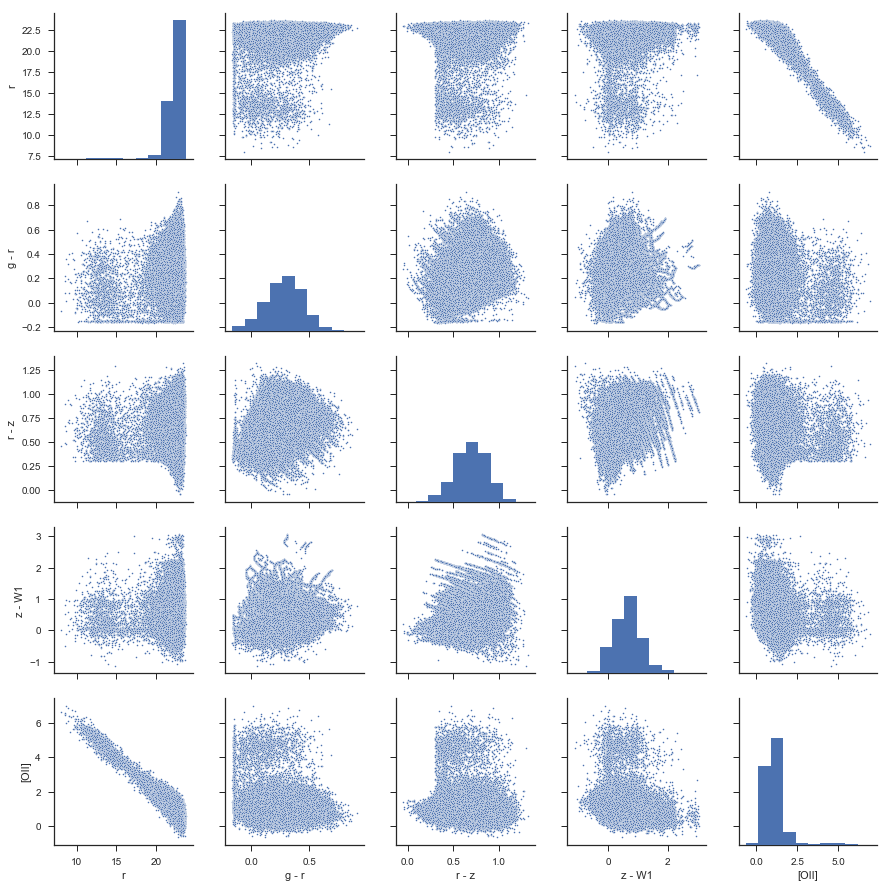

In [37]:
pairplot(df)

In [38]:
def qa_bic(ncomp, bic, title=''):
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(ncomp, bic, marker='s', ls='-')
    ax.set_xlabel('Number of Gaussian Components')
    ax.set_ylabel('Bayesian Information Criterion')
    ax.set_title(title)

In [48]:
def getbic(df, ncomp=[5]):
    X = df[df.columns]
    mog = [GMM(n_components=nc).fit(X) for nc in ncomp]
    bic = [_mog.bic(X) for _mog in mog]
    #bic = [GMM(n_components=nc).fit(X).bic(X) for nc in ncomp]
    return bic

In [ ]:
ncomp = 10
mog = GMM(n_components=10).fit(info[qsocols])

In [49]:
ncomparray = np.arange(5, 10)

In [50]:
%time bic = getbic(df, ncomp=ncomparray)

CPU times: user 52.8 s, sys: 2.37 s, total: 55.2 s
Wall time: 14.8 s


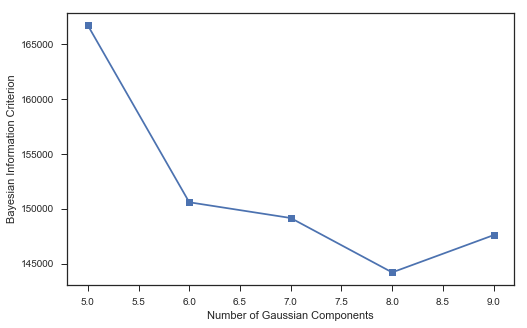

In [51]:
qa_bic(ncomparray, bic)

In [ ]:
mog = GMM(n_components=10).fit(info[qsocols])

In [ ]:
stop

In [ ]:
elg = np.where( (truth['OIIFLUX'] != -1) & ( (targets['DESI_TARGET'] & desi_mask.mask(targ) != 0) ) &
               (truth['TRUEZ'] > 1.0) & (truth['TRUEZ'] < 1.05) 
              )[0]
plt.scatter(truth['FLUX_R'][elg], truth['OIIFLUX'][elg], s=5)

In [ ]:
plt.scatter(rmag[elg], np.log10(oiiflux[elg]), s=5)

In [ ]:
plt.scatter(zobj[elg], np.log10(oiiflux[elg]), s=5)

In [ ]:
ww = np.where( np.log10(oiiflux[elg]) > -13)
truth[elg][ww]
